## Importimi i librarive

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input, Flatten, merge, Lambda, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
import itertools

from nltk.tokenize import RegexpTokenizer

from sklearn.utils import shuffle

import re

## Ngarkimi i datasetit dhe përcaktimi i variablës hyrëse dhe asaj dalëse (target)

In [2]:
data = pd.read_csv("../Dataseti/trainset.csv")

comments = data['Comment']
y = data['Final annotation']

## Numri i komenteve me sarkazëm (1) dhe pa sarkazëm (0)

In [3]:
y.value_counts()

0    2432
1    1356
Name: Final annotation, dtype: int64

## Parametrat hyrës

In [4]:
MAX_SEQUENCE_LENGTH = 20  
MAX_NB_WORDS = 10000      
EMBEDDING_DIM = 300       

## Procesimi i komenteve 

In [5]:
def preprocess_text(sen):
 
    sentence = sen
    # Remove everything except a-z, A-Z, and chars like Ë, ë, Ç, ç
    sentence = re.sub('[^a-zA-Z0-9ËëÇç]', ' ', sentence)
 
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
 
    return sentence

## Vendosja e komenteve në një listë të vetme

In [6]:
docs = []  ## <class 'list'>
for sen in comments:
    docs.append(preprocess_text(sen))

## Shembull i krijimit të një fjalori me indeksa për çdo fjalë të fjalisë

In [7]:
some_comments = [
    "Shumë respekte për punën tuaj!", 
    "Një falenderim i madh për institutin!" 
            ] 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(some_comments) 
 
tokenizer.word_index

{'për': 1,
 'shumë': 2,
 'respekte': 3,
 'punën': 4,
 'tuaj': 5,
 'një': 6,
 'falenderim': 7,
 'i': 8,
 'madh': 9,
 'institutin': 10}

## Vendojsa e indeksave të secilës fjalë në një listë

In [8]:
sequences = tokenizer.texts_to_sequences(some_comments) 
sequences

[[2, 3, 1, 4, 5], [6, 7, 8, 9, 1, 10]]

## Vendosja e indeksave të fjalëve në një varg  2-dimensional me madhësi të njëjtë

In [9]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x   ## <class 'numpy.ndarray'>    shape: (2, 20)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
         3,  1,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  7,
         8,  9,  1, 10]])

## Numri total i komenteve 

In [10]:
len(docs)

3788

## Enkodimi i anotimit final - "one-hot encoding"

In [11]:
encoder = LabelEncoder()

encoder.fit(y) # encoder.fit([1, 1, 2, 6]) LabaleEncoder()
# encoder.classes_ 
# array([1, 2, 6])

encoded_y = encoder.transform(y)
# array([0, 0, 1, 2]...)

# encoder.inverse_transform([0, 0, 1, 2])
# array([1, 1, 2, 6])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)
print(dummy_y)
# Converts a class vector(integers) to binary class matrix.

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


## Definimi i funksionit që tregon humbjet dhe saktësinë e modelit përmes grafikëve

In [12]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1) # range(1, 251) 
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Definimi i funksionit që tregon rezultatet e detajizuara për modelin e trajnuar

In [13]:
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size = 16,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=4))

## Vendosja e indeksave të fjalëve në një varg me madhësi të njëjtë

In [14]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, lower=True )

tokenizer.fit_on_texts(docs)

sequences = tokenizer.texts_to_sequences(docs)

word_index = tokenizer.word_index

print('U gjetën %s tokena unik.' % len(word_index))

# convert text to sequence of tokens and pad them to ensure equal length vectors 
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x

U gjetën 9459 tokena unik.


array([[   0,    0, 2316, ..., 3584,  215,  198],
       [   0,    0,    0, ...,  247,    7,  756],
       [   0,    0,    0, ..., 2318, 3585, 3586],
       ...,
       [   0,    0,    0, ...,    3,  529, 9454],
       [   0,    0,    0, ...,    1, 3153,  308],
       [  10,    8,  601, ...,    8,    2, 2404]])

## Ndarja e të dhënave në trajnuese dhe testuese

In [15]:
seed = 20
 
x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, 	train_size=0.8, random_state=seed)
 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 	train_size=0.7, random_state=seed)

In [16]:
from numpy.random import seed
import tensorflow as tf

seed(1)

tf.random.set_seed(2)

## Përcaktimi i arkitekturës së modelit

In [17]:
from keras.layers import GlobalMaxPooling1D

model = Sequential()

model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length = x.shape[1]))

model.add(Conv1D(32, 3, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2838000   
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 32)            28832     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,866,898
Trainable params: 2,866,898
Non-trainable params: 0
_________________________________________________________________
None


## Procesi i trajnimit të modelit

In [18]:
History=model.fit(x_train, y_train, epochs = 50, batch_size = 16, verbose=2, 
                           validation_data=(x_val,y_val), shuffle=True)

Epoch 1/50
133/133 - 9s - loss: 0.6564 - acc: 0.6143 - val_loss: 0.5974 - val_acc: 0.7107
Epoch 2/50
133/133 - 6s - loss: 0.4799 - acc: 0.7992 - val_loss: 0.5391 - val_acc: 0.7492
Epoch 3/50
133/133 - 6s - loss: 0.2230 - acc: 0.9241 - val_loss: 0.6015 - val_acc: 0.7283
Epoch 4/50
133/133 - 6s - loss: 0.0762 - acc: 0.9797 - val_loss: 0.6734 - val_acc: 0.7382
Epoch 5/50
133/133 - 6s - loss: 0.0339 - acc: 0.9906 - val_loss: 0.7469 - val_acc: 0.7305
Epoch 6/50
133/133 - 6s - loss: 0.0195 - acc: 0.9934 - val_loss: 0.8059 - val_acc: 0.7393
Epoch 7/50
133/133 - 6s - loss: 0.0149 - acc: 0.9934 - val_loss: 0.8503 - val_acc: 0.7338
Epoch 8/50
133/133 - 6s - loss: 0.0122 - acc: 0.9948 - val_loss: 0.9009 - val_acc: 0.7283
Epoch 9/50
133/133 - 6s - loss: 0.0112 - acc: 0.9953 - val_loss: 0.9270 - val_acc: 0.7415
Epoch 10/50
133/133 - 6s - loss: 0.0110 - acc: 0.9939 - val_loss: 0.9556 - val_acc: 0.7349
Epoch 11/50
133/133 - 6s - loss: 0.0080 - acc: 0.9962 - val_loss: 0.9933 - val_acc: 0.7437
Epoch 12

## Humbjet dhe saktësia e modelit të trajnuar

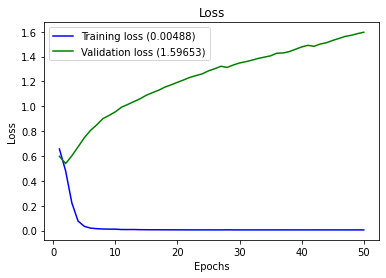

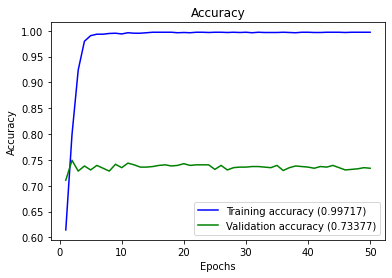

In [19]:
plot_history(History)

## Rezultatet e detajizuara të modelit të trajnuar

In [20]:
full_multiclass_report(model, x_val, y_val, encoder.inverse_transform(np.arange(2)))

Accuracy : 0.7337733773377337

Classification Report
              precision    recall  f1-score   support

           0     0.7851    0.8168    0.8007       595
           1     0.6241    0.5764    0.5993       314

    accuracy                         0.7338       909
   macro avg     0.7046    0.6966    0.7000       909
weighted avg     0.7295    0.7338    0.7311       909

